In [1]:
%config IPCompleter.greedy=True

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import argparse
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from torch.autograd import Variable

import seaborn as sns

import h5py
#import pywt

%pip install pingouin

import pingouin as pg
%pip install matplotlib -U
%pip install Pillow -U

import scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
print(os.getcwd())

/home/ubuntu/Desktop/matt/Shark Behavior Classification


In [3]:
all_data = './datasets/all_data'

paths = [all_data + '/feeding/csv/Feeding_25Hz_',
         all_data + '/swimming/csv/Swimming_25Hz_',
         all_data + '/resting/csv/Resting_25Hz_',
         all_data + '/ndm/csv/NDM_25Hz_']

In [4]:
'''
Load datasets into pandas
'''
dfs = []

for i in range(7):
    df = pd.concat((pd.read_csv(path + str(i+1) + '.csv',
                                index_col=['Date_Time'],
                                parse_dates=['Date_Time'],
                                infer_datetime_format=True) for path in paths), ignore_index=False, sort=False).iloc[:, 1:9]

    
    df = df.replace(to_replace={"Non directed motion": "NDM"})
    
    dfs.append(df)

In [5]:
static_stats = pd.DataFrame()
dynamic_stats = pd.DataFrame()

static_norms = pd.DataFrame()
dynamic_norms = pd.DataFrame()

for i, df in enumerate(dfs):
    static_stats['Exp ' + str(i+1)] = pd.concat([df[['X_static', 'Y_static', 'Z_static']].max(),
                                                 df[['X_static', 'Y_static', 'Z_static']].min(),
                                                 df[['X_static', 'Y_static', 'Z_static']].mean(),
                                                 df[['X_static', 'Y_static', 'Z_static']].std()], keys=['Max', 'Min', 'Mean', 'Std'])
    
    dynamic_stats['Exp ' + str(i+1)] = pd.concat([df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].max(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].min(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].mean(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].std()], keys=['Max', 'Min', 'Mean', 'Std'])

    static_norms['Exp ' + str(i+1)] = pd.concat([pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].max())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].min())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].mean())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].std()))], keys=['Max', 'Min', 'Mean', 'Std'])
    
    dynamic_norms['Exp ' + str(i+1)] = pd.concat([pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].max())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].min())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].mean())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].std()))], keys=['Max', 'Min', 'Mean', 'Std'])

    
    

In [6]:
static_stats

Exp 1     Exp 2     Exp 3     Exp 4     Exp 5     Exp 6  \
Max  X_static  0.077032  1.024170  1.006630  0.111045  0.120679  0.910788   
     Y_static  0.156563  1.004630  1.002600  0.975836  0.088644 -0.021613   
     Z_static  0.824636  1.014490  0.973284  0.985417  0.926976  0.022193   
Min  X_static -0.950087 -0.253547 -0.211931 -0.914067 -0.906773 -0.781672   
     Y_static -0.988508 -0.658232 -0.551303 -0.314020 -0.978964 -1.000050   
     Z_static -0.821353 -0.976028 -0.987348 -0.979845 -0.835004 -0.901816   
Mean X_static -0.400417  0.446350  0.369005 -0.257957 -0.394168  0.068859   
     Y_static -0.879964  0.718481  0.844067  0.631873 -0.763511 -0.868546   
     Z_static  0.003688  0.306530  0.075490 -0.516440  0.113675 -0.381761   
Std  X_static  0.094312  0.166261  0.238551  0.103277  0.154507  0.173428   
     Y_static  0.078235  0.283534  0.230427  0.183568  0.230552  0.127392   
     Z_static  0.156091  0.347395  0.273057  0.427820  0.295407  0.133636   

                  Exp 7  
Max  X_static  0.270196  
     Y_static  0.974056  
     Z_static  0.992609  
Min  X_static -0.931509  
     Y_static -0.986103  
     Z_static -0.978284  
Mean X_static -0.483220  
     Y_static  0.711312  
     Z_static -0.166788  
Std  X_static  0.129881  
     Y_static  0.212119  
     Z_static  0.345494

In [52]:
dynamic_stats

Exp 1     Exp 2     Exp 3     Exp 4     Exp 5  \
Max  X_dynamic  0.917003  1.412390  0.475683  1.387760  0.552457   
     Y_dynamic  1.316170  0.990695  0.520234  0.755899  0.612059   
     Z_dynamic  0.690294  0.946936  1.035980  0.914963  0.818436   
Min  X_dynamic -0.608845 -0.961168 -0.917072 -1.031950 -0.574540   
     Y_dynamic -0.754519 -1.327120 -1.028350 -1.307330 -0.451837   
     Z_dynamic -1.035620 -1.757400 -1.077940 -0.976593 -0.717468   
Mean X_dynamic  0.000003 -0.000029  0.000006 -0.000004  0.000026   
     Y_dynamic -0.000002  0.000046  0.000019  0.000006 -0.000125   
     Z_dynamic  0.000011 -0.000016 -0.000015 -0.000018 -0.000140   
Std  X_dynamic  0.022189  0.044530  0.016178  0.091395  0.104998   
     Y_dynamic  0.017005  0.034681  0.014545  0.062667  0.073345   
     Z_dynamic  0.025699  0.038335  0.018086  0.093815  0.114178   

                       Exp 6     Exp 7  
Max  X_dynamic  4.894900e-01  1.298910  
     Y_dynamic  6.033030e-01  0.954513  
     Z_dynamic  6.555320e-01  1.247020  
Min  X_dynamic -7.216680e-01 -1.030680  
     Y_dynamic -5.282180e-01 -1.216800  
     Z_dynamic -8.691920e-01 -0.826656  
Mean X_dynamic -3.990769e-07  0.000002  
     Y_dynamic -4.022575e-06  0.000003  
     Z_dynamic -2.418656e-05  0.000005  
Std  X_dynamic  4.146162e-02  0.057362  
     Y_dynamic  3.319764e-02  0.044634  
     Z_dynamic  4.746022e-02  0.062550

In [53]:
static_norms

,,Exp 1,Exp 2,Exp 3,Exp 4,Exp 5,Exp 6,Exp 7
Max,0,0.842894,1.757099,1.722148,1.391270,0.938992,0.911315,1.416709
Min,0,1.598260,1.204237,1.150524,1.376308,1.574115,1.557043,1.672468
Mean,0,0.966791,0.899669,0.924290,0.855871,0.866741,0.951239,0.875947
Std,0,0.198443,0.478244,0.429609,0.476858,0.405330,0.253307,0.425711


In [54]:
dynamic_norms

,,Exp 1,Exp 2,Exp 3,Exp 4,Exp 5,Exp 6,Exp 7
Max,0,1.746340,1.967996,1.253065,1.826039,1.161750,1.016512,2.037970
Min,0,1.418626,2.402820,1.749423,1.930742,1.024213,1.247122,1.796180
Mean,0,0.000012,0.000057,0.000025,0.000019,0.000190,0.000025,0.000006
Std,0,0.037973,0.068229,0.028291,0.145194,0.171583,0.071229,0.095891


## Density Estimation for ODBA Distributions

In [7]:
def kde_plot(data_df, feature='ODBA', log_scale=False):
    label_list = data_df['Label'].unique().tolist()
    for label in label_list:
        class_data = data_df.loc[data_df['Label'] == label][feature]

        # Draw the density plot for original data
        ax = sns.kdeplot(data=class_data, legend=True, log_scale=log_scale)

    ax.legend(label_list)

    plt.show()
    plt.clf()

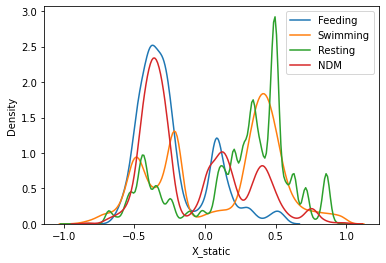

KeyboardInterrupt: 

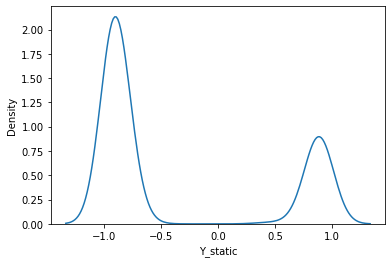

In [8]:
kde_plot(pd.concat(dfs), feature='X_static')
kde_plot(pd.concat(dfs), feature='Y_static')
kde_plot(pd.concat(dfs), feature='Z_static')
kde_plot(pd.concat(dfs), feature='X_dynamic', log_scale=True)
kde_plot(pd.concat(dfs), feature='Y_dynamic', log_scale=True)
kde_plot(pd.concat(dfs), feature='Z_dynamic', log_scale=True)

In [15]:
for i, df in enumerate(dfs):
    print("Normality test for Exp " + str(i+1))
    f_data = df.loc[df['Label'] == 'NDM']['X_dynamic']
#     f_data = df[['ODBA']]
#     log_f = np.log10(f_data)
    
#     plt.hist(f_data, bins='auto')
#     plt.show()

#     plt.hist(log_f, bins='auto')
#     plt.show()

#     sm.qqplot(f_data, line ='r')
#     plt.show()
    
#     sm.qqplot(log_f, line ='r')
#     plt.show()
    
    print(scipy.stats.normaltest(f_data))
#     print(scipy.stats.normaltest(log_f))
    
#     print(pg.normality(f_data, alpha=0.05))
#     print(pg.normality(log_f, alpha=0.05))

#     rand_idx = np.random.randint(0,len(df)-5000)
#     print(pg.normality(log_f[rand_idx:rand_idx+5000]), alpha=0.05)
    
#     print(pg.multivariate_normality(df[['X_dynamic', 
#                                         'Y_dynamic', 
#                                         'Z_dynamic']][rand_idx:rand_idx+5000], alpha=0.05))

Normality test for Exp 1
NormaltestResult(statistic=10456.260645426632, pvalue=0.0)
Normality test for Exp 2
NormaltestResult(statistic=2651.0667847342456, pvalue=0.0)
Normality test for Exp 3
NormaltestResult(statistic=3773.341732922815, pvalue=0.0)
Normality test for Exp 4
NormaltestResult(statistic=35.82541614306982, pvalue=1.6619185240828925e-08)
Normality test for Exp 5
NormaltestResult(statistic=493.4593772574824, pvalue=7.025184053167471e-108)
Normality test for Exp 6
NormaltestResult(statistic=4953.784259320618, pvalue=0.0)
Normality test for Exp 7
NormaltestResult(statistic=591.6500556019514, pvalue=3.3482880831153435e-129)


## Normality Tests

In [ ]:
mean, cov, n = [4, 5], [(0.6, 0.4), (0.4, 0.6)], 5000
x, y = np.random.multivariate_normal(mean, cov, n).T

In [ ]:
print(pg.normality(x))
print(pg.normality(y))
print(pg.multivariate_normality(np.column_stack((x, y))))

In [ ]:
# plt.hist(x, bins='auto')
# plt.show()
# plt.hist(y, bins='auto')
# plt.show()

plt.hist2d(x, y, bins=(69, 69), cmap='gray')
plt.show()

In [ ]:
%pip install statsmodels
import statsmodels.api as sm

In [ ]:
sm.qqplot(y, line ='45')
plt.show()

## Data split

In [9]:
# Train: 1, 2, 3, 4, 7
# Val: 6
# Test: 5
train_df = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3], dfs[6]])
val_df = dfs[5]
test_df = dfs[4]

In [10]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1646579, 8)
(77650, 8)
(16775, 8)


In [11]:
features = ['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']

train_data = train_df[features + ['Label']]
val_data = val_df[features + ['Label']]
test_data = test_df[features + ['Label']]

In [12]:
print([df[features].isna().values.any() for df in dfs])
print(train_data[features].isna().values.any())
print(val_data[features].isna().values.any())
print(test_data[features].isna().values.any())

[False, False, False, False, False, False, False]
False
False
False


In [13]:
for column in features:
    mean = np.mean(train_data[column])
    std  = np.std(train_data[column])
    
    train_data[column] = train_data[column].map(lambda x: (x-mean)/std)
    val_data[column]   = val_data[column].map(lambda x: (x-mean)/std)
    test_data[column]  = test_data[column].map(lambda x: (x-mean)/std)

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [14]:
print(np.mean(train_data[features]))
print(np.std(train_data[features]))

print(np.mean(val_data[features]))
print(np.std(val_data[features]))

print(np.mean(test_data[features]))
print(np.std(test_data[features]))

X_static     1.039045e-14
Y_static    -1.001358e-13
Z_static     1.205761e-14
X_dynamic    2.604293e-17
Y_dynamic    3.610452e-17
Z_dynamic    1.876561e-17
dtype: float64
X_static     1.0
Y_static     1.0
Z_static     1.0
X_dynamic    1.0
Y_dynamic    1.0
Z_dynamic    1.0
dtype: float64
X_static    -0.296300
Y_static    -2.296768
Z_static    -1.297910
X_dynamic    0.000275
Y_dynamic   -0.000951
Z_dynamic   -0.000327
dtype: float64
X_static     0.422972
Y_static     0.209462
Z_static     0.345657
X_dynamic    0.964835
Y_dynamic    1.016925
Z_dynamic    1.143621
dtype: float64
X_static    -1.425582
Y_static    -2.124064
Z_static    -0.016430
X_dynamic    0.000889
Y_dynamic   -0.004651
Z_dynamic   -0.003128
dtype: float64
X_static     0.376818
Y_static     0.379074
Z_static     0.764068
X_dynamic    2.443314
Y_dynamic    2.246670
Z_dynamic    2.751217
dtype: float64


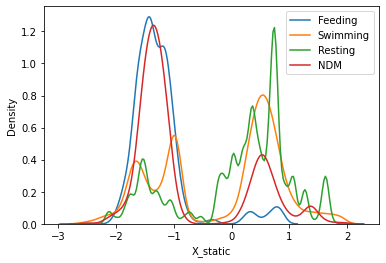

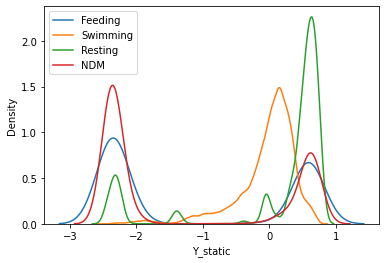

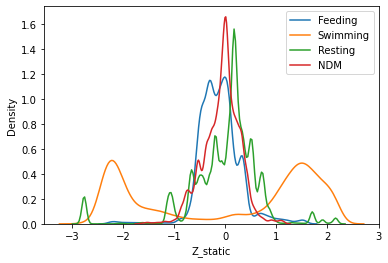

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


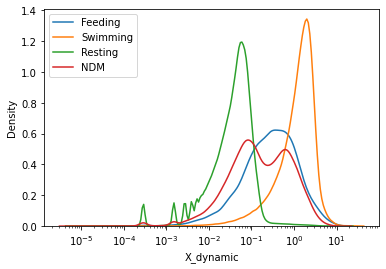

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


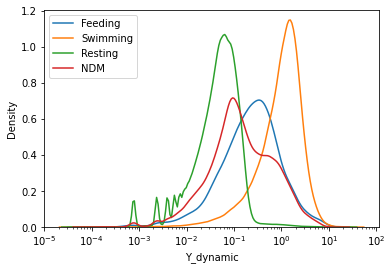

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


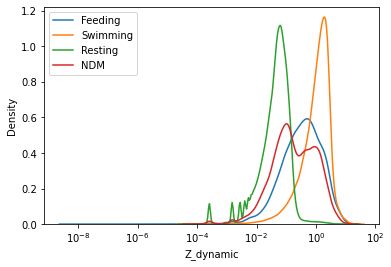

<Figure size 432x288 with 0 Axes>

In [26]:
kde_plot(train_data, feature='X_static')
kde_plot(train_data, feature='Y_static')
kde_plot(train_data, feature='Z_static')
kde_plot(train_data, feature='X_dynamic', log_scale=True)
kde_plot(train_data, feature='Y_dynamic', log_scale=True)
kde_plot(train_data, feature='Z_dynamic', log_scale=True)

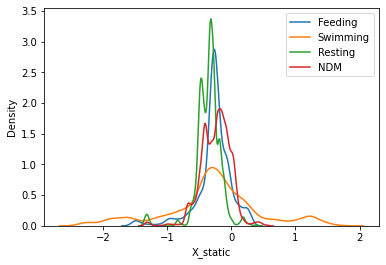

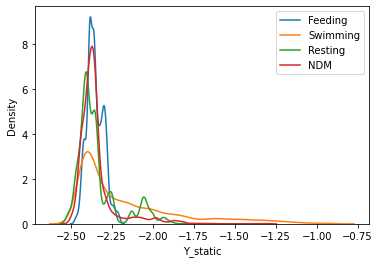

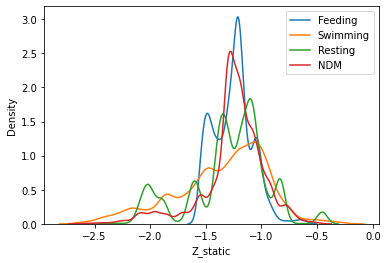

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


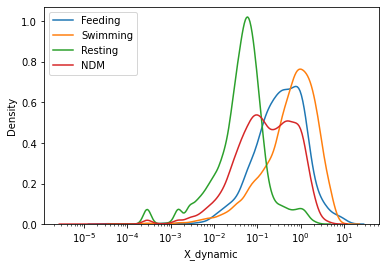

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


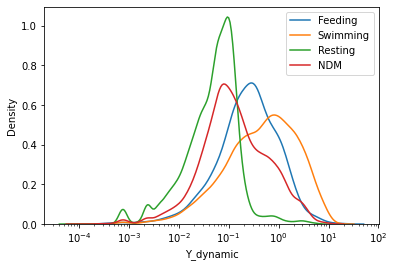

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


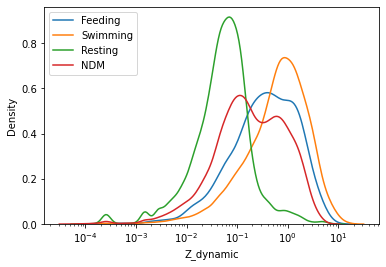

<Figure size 432x288 with 0 Axes>

In [27]:
kde_plot(val_data, feature='X_static')
kde_plot(val_data, feature='Y_static')
kde_plot(val_data, feature='Z_static')
kde_plot(val_data, feature='X_dynamic', log_scale=True)
kde_plot(val_data, feature='Y_dynamic', log_scale=True)
kde_plot(val_data, feature='Z_dynamic', log_scale=True)

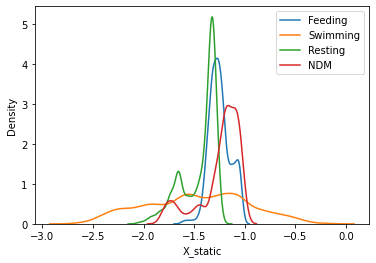

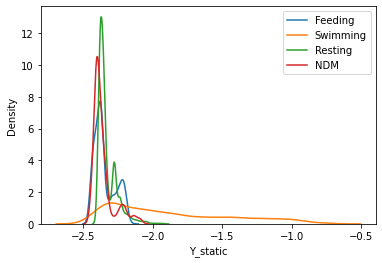

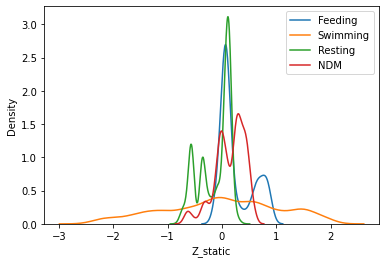

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


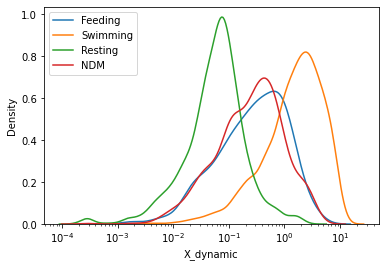

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


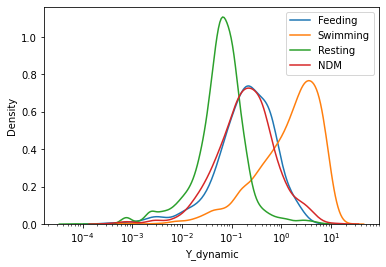

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


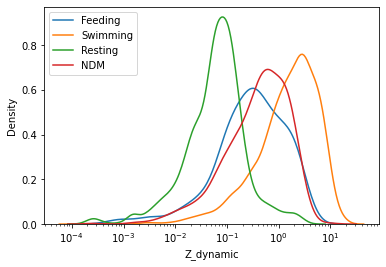

<Figure size 432x288 with 0 Axes>

In [28]:
kde_plot(test_data, feature='X_static')
kde_plot(test_data, feature='Y_static')
kde_plot(test_data, feature='Z_static')
kde_plot(test_data, feature='X_dynamic', log_scale=True)
kde_plot(test_data, feature='Y_dynamic', log_scale=True)
kde_plot(test_data, feature='Z_dynamic', log_scale=True)

## Group contiguous time intervals

In [15]:
def group_times(df):
    time_diff = df.index.to_series().diff()
    breaks = time_diff > pd.Timedelta('1s')
    groups = breaks.cumsum()
    
    df['Group'] = groups
    
    return df

In [16]:
train_data = group_times(train_data)
val_data = group_times(val_data)
test_data = group_times(test_data)

In [79]:
def sample_sequences(df, num_samples=None, seq_len=50, dims=1, train=True):
    X = []
    Y = []
    
    label_list = ['Feeding', 'Swimming', 'Resting', 'NDM']
    
    for idx, label in enumerate(label_list):
        print(str(idx) + ": " + label)
        
        class_df = df.loc[df['Label'] == label]
        if train:
            X_class = np.zeros((num_samples, seq_len, dims), dtype=np.float32)
            Y_class = np.full((num_samples, 1), idx, dtype=np.int64)
            
            for i in range(num_samples):
                groups = class_df['Group'].unique()
                chunk_idx = groups[np.random.randint(len(groups))]
                    
                data = class_df.loc[class_df['Group'] == chunk_idx][features].to_numpy()
                
                rand = np.random.randint(len(data)-seq_len)
                
                if dims == 1:
                    X_class[i] = np.expand_dims(data[rand:rand+seq_len], axis=1)
                else:
                    X_class[i] = data[rand:rand+seq_len]
                
        else:
            data = df.loc[df['Label'] == label][features].to_numpy()
            
            num_samples = len(data)//50
            print(num_samples)
            
            X_class = np.zeros((num_samples, seq_len, dims), dtype=np.float32)
            Y_class = np.full((num_samples, 1), idx, dtype=np.int64)
            
            for i in range(num_samples):
                if dims == 1:
                    X_class[i] = np.expand_dims(data[seq_len*i:seq_len*(i+1)], axis=1)
                else:
                    X_class[i] = data[seq_len*i:seq_len*(i+1)]
                    
        X.append(X_class)
        Y.append(Y_class)
        
    return X, Y

In [80]:
X_train, Y_train = sample_sequences(train_data, num_samples=10000, dims=6)

0: Feeding
1: Swimming
2: Resting
3: NDM


In [81]:
X_train = np.concatenate(X_train)
Y_train = np.concatenate(Y_train)

In [82]:
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train, random_state=33)

In [83]:
X_val, Y_val = sample_sequences(val_data, num_samples=2000, dims=6)

0: Feeding
1: Swimming
2: Resting
3: NDM


In [84]:
X_val

[array([[[ 0.2453431 , -2.302677  , -1.0961338 , -2.202243  ,
          -0.2079063 , -2.3044033 ],
         [ 0.25004044, -2.2997634 , -1.1023287 , -2.965636  ,
          -0.62057525, -1.9749211 ],
         [ 0.25461343, -2.2965078 , -1.1077191 , -1.0996981 ,
           5.3013163 , -0.3236912 ],
         ...,
         [ 0.27139312, -2.308315  , -1.1810069 , -0.8940851 ,
          -0.22232203,  1.4864196 ],
         [ 0.26948833, -2.30943   , -1.1792557 ,  4.179424  ,
          -0.20156534, -1.1308904 ],
         [ 0.26770794, -2.3102849 , -1.1776391 ,  2.9850316 ,
           1.3704888 ,  0.9565647 ]],
 
        [[-0.29976103, -2.3036175 , -1.4868014 , -0.05115908,
           0.04855207, -0.02480448],
         [-0.29976103, -2.303532  , -1.4881516 , -0.22053862,
           0.04695918, -0.02480448],
         [-0.29950738, -2.303361  , -1.4892275 , -0.210858  ,
           0.04377338, -0.21526358],
         ...,
         [-0.28073752, -2.2876272 , -1.5304834 ,  0.16032507,
          -0.249

In [85]:
X_val = np.concatenate(X_val)
Y_val = np.concatenate(Y_val)

In [86]:
X_val, Y_val = shuffle(X_val, Y_val, random_state=33)

In [87]:
print(X_train.mean())
print(X_train.std())

print(X_val.mean())
print(X_val.std())

-0.112150654
1.3380746
-0.66006523
1.2345648


In [88]:
from collections import Counter

print(Counter(np.squeeze(Y_train).tolist()))
print(Counter(np.squeeze(Y_val).tolist()))

Counter({0: 10000, 3: 10000, 2: 10000, 1: 10000})
Counter({0: 2000, 3: 2000, 1: 2000, 2: 2000})


In [89]:
test_data.count()

X_static     16775
Y_static     16775
Z_static     16775
X_dynamic    16775
Y_dynamic    16775
Z_dynamic    16775
Label        16775
Group        16775
dtype: int64

In [90]:
X_test, Y_test = sample_sequences(test_data, train=False, dims=6)

0: Feeding
17
1: Swimming
159
2: Resting
123
3: NDM
35


In [91]:
X_test = np.concatenate(X_test)
Y_test = np.concatenate(Y_test)

In [92]:
print(X_test.shape)
print(Y_test.shape)

(334, 50, 6)
(334, 1)


In [94]:
test_data['Label'].value_counts()//50

Swimming    159
Resting     123
NDM          35
Feeding      17
Name: Label, dtype: int64

In [96]:
sum(test_data['Label'].value_counts()//50)

334

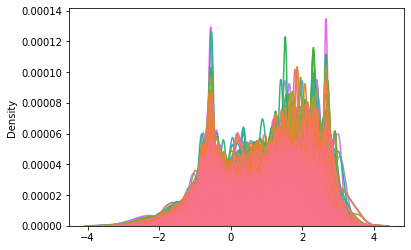

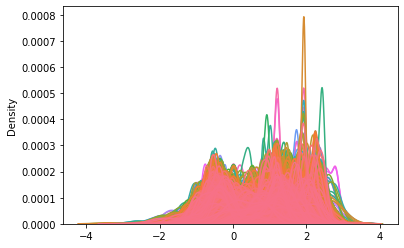

<Figure size 432x288 with 0 Axes>

In [272]:
## This estimates the distribution of each sequence (40,000/2,000 distributions, each of 50 samples)
ax = sns.kdeplot(data=np.squeeze(X_train).T, legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=np.squeeze(X_val).T, legend=False)

plt.show()
plt.clf()

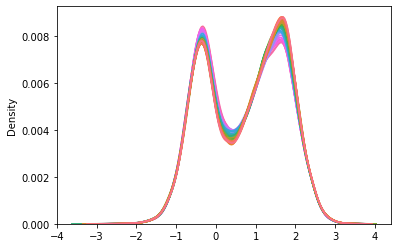

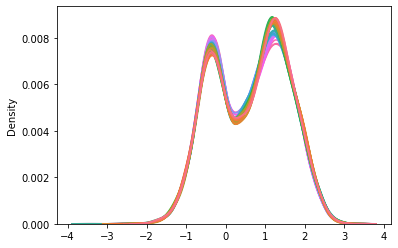

<Figure size 432x288 with 0 Axes>

In [273]:
## This estimates the distribution of each sequence element (50 distributions, each of 40,000/2,000 samples)
ax = sns.kdeplot(data=np.squeeze(X_train), legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=np.squeeze(X_val), legend=False)

plt.show()
plt.clf()

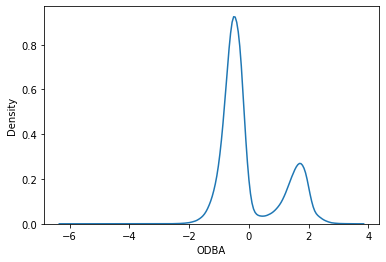

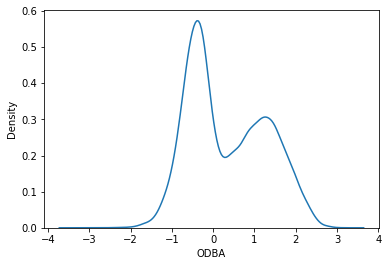

<Figure size 432x288 with 0 Axes>

In [274]:
## This estimates the distribution over the train and val sets, respectively
ax = sns.kdeplot(data=train_odba['ODBA'], legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=val_odba['ODBA'], legend=False)

plt.show()
plt.clf()

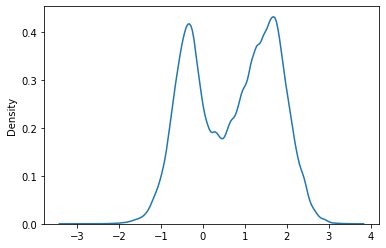

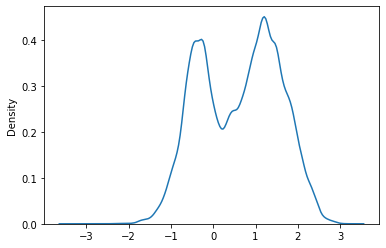

<Figure size 432x288 with 0 Axes>

In [275]:
ax = sns.kdeplot(data=X_train.flatten(), legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=X_val.flatten(), legend=False)

plt.show()
plt.clf()

In [99]:
def write(data, gts, outfile):
    '''
        This function writes the pre-processed image data to a HDF5 file
        Args:
          data: numpy.array, image data as numpy array
          outfile: string, path to write file to
    '''
    print("---------------------------------------")
    print("Saving data")
    print("---------------------------------------\n")
    with h5py.File(outfile, "w") as f:
        f.create_dataset("features", data=data, dtype=data.dtype)
        f.create_dataset("gts", data=gts, dtype=gts.dtype)

def load(infile, dataset):
    '''
        This function loads the image data from a HDF5 file 
        Args:
          outfile: string, path to read file from
          
        Returns:
          f["image"][()]: numpy.array, image data as numpy array
    '''
    print("---------------------------------------")
    print("Loading data")
    print("---------------------------------------\n")
    with h5py.File(infile, "r") as f:
        return f[dataset][()]

In [100]:
write(X_train, Y_train, './datasets/data/2d/train/data.hdf5')
write(X_val, Y_val, './datasets/data/2d/val/data.hdf5')
write(X_test, Y_test, './datasets/data/2d/test/orig/data.hdf5')

---------------------------------------
Saving data
---------------------------------------

---------------------------------------
Saving data
---------------------------------------

---------------------------------------
Saving data
---------------------------------------



In [102]:
X_train.shape

(40000, 50, 6)

In [103]:
X_val.shape

(8000, 50, 6)

In [104]:
X_test.shape

(334, 50, 6)